Steps:

- Load data and visualize a sample of them
- Check for distribution across classes

- Give ERM/IRM a shot to improve the performance

In [4]:
# Run following commands if running on local
# !pip install kaggle

# Download kaggle.json from kaggle website under profile->new API section
# !kaggle competitions download -c plant-seedlings-classification
# !unzip -q plant-seedlings-classification.zip

In [5]:
# # Kaggle specific variables comment if running somewhere else
# import os

# os.chdir('/kaggle/input/plant-seedlings-classification/')
# SAVE_MODEL = '../../working/best_model.pt'

In [6]:
# Folder structure
# Training data
# contains images in 12 folders, each folder contains images of a single class
# Test data
# contains all images in a single folder

# Load the data
from torchvision import datasets, transforms
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
size = (
    (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"])
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

# How many transformations are good?
transforms = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.Resize(size),
    # RandomResizedCrop being used here --> https://huggingface.co/docs/transformers/main/en/tasks/image_classification
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(size),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(),
    transforms.RandomInvert(),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

dataset = datasets.ImageFolder('./train', transform=transforms)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### Class Distribution

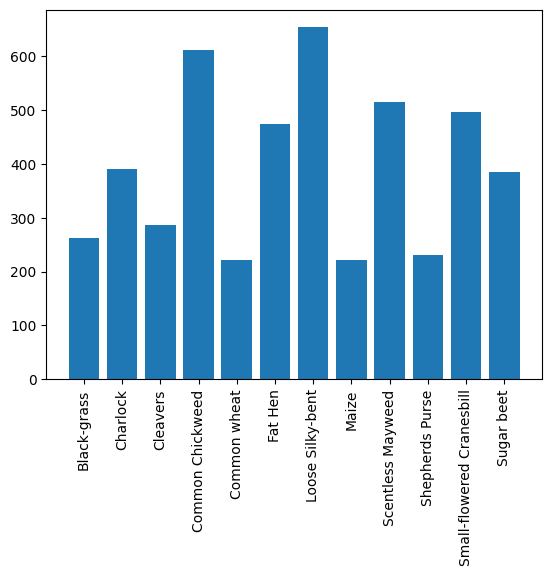

In [7]:
# Plot class distribution
from collections import Counter
import matplotlib.pyplot as plt

distribution = dict(Counter(dataset.targets))

# Plot class distribution histogram
plt.bar(list(map(lambda x: dataset.classes[x], distribution.keys())), distribution.values())
plt.xticks(rotation=90)
plt.show()

### Sampling imbalance classes

In [8]:
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

def sampler(indices):
    labels = [dataset.targets[x] for x in indices]
    print(f'label length: {len(labels)}')
    distribution = dict(Counter(labels))
    class_weights = {k: 1/v for k, v in distribution.items()}

    samples_weight = np.array([class_weights[t] for t in labels])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [9]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from collections import Counter

# Split validation data from training data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices) # shuffle the dataset before splitting into train and val
print(f'dataset_size: {dataset_size}')

split = int(np.floor(0.8 * dataset_size))
train_indices, val_indices = indices[:split], indices[split:]

# 
BATCH_SIZE = 24

train = DataLoader(Subset(dataset, train_indices), sampler=sampler(train_indices), batch_size=BATCH_SIZE)
val = DataLoader(Subset(dataset, val_indices), sampler=sampler(val_indices), batch_size=BATCH_SIZE)

dataset_size: 4750
label length: 3800
label length: 950


### Visualize distribution after sampling

In [ ]:
# import plt
from matplotlib import pyplot as plt

In [10]:
# # Plot class distribution histogram for training data
# class_counts = [0]*len(dataset.classes)

# for i, (_, label) in enumerate(train):
#     for l in label:
#         class_counts[l] += 1

# # Plot class distribution histogram
# plt.bar(dataset.classes, class_counts)
# plt.xticks(rotation=90)
# plt.show()

In [11]:
# # Plot class distribution histogram for validation data
# class_counts = [0]*len(dataset.classes)

# for i, (_, label) in enumerate(val):
#     for l in label:
#         class_counts[l] += 1

# # Plot class distribution histogram
# plt.bar(dataset.classes, class_counts)
# plt.xticks(rotation=90)
# plt.show()

### Visualize images

In [12]:
# def visualizeBatch(batch, classes=None):
#     # sample 8 indexes from BATCH_SIZE
#     indexes = np.random.choice(BATCH_SIZE, 8, replace=False)
#     for i, j in enumerate(indexes):
#         image, idx = batch[0][j], batch[1][j]
        
#         ax = plt.subplot(2, 4, i + 1)
#         image = image.cpu().numpy()
#         image = image.transpose((1, 2, 0))
#         image = (255.0 * image).astype('uint8')
        
#         plt.imshow(image)
#         if classes is not None:
#             plt.title(classes[idx])
#         plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

In [13]:
# trainBatch = next(iter(train))
# visualizeBatch(trainBatch, dataset.classes)

In [14]:
# testBatch = next(iter(test))
# visualizeBatch(testBatch)

### FineTuning resnet-50

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_built() else 
                      'cpu')

In [16]:
from transformers import ResNetModel, ResNetConfig
from torch import nn
from transformers.modeling_outputs import ImageClassifierOutputWithNoAttention

# model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50").to(device)

class CustomResNet(nn.Module):
    def __init__(self, checkpoint="microsoft/resnet-50", num_classes=12):
        super(CustomResNet, self).__init__()
        self.num_classes = num_classes
        self.model = ResNetModel.from_pretrained(checkpoint)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.1)
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = torch.nn.Linear(2048, num_classes)
    
    def forward(self, x, labels=None):
        x = self.model(x)
        x = self.pooling(x[0])
        x = self.flatten(x)
        x = self.dropout(x)
        logits = self.classifier(x.view(-1, 2048))
        
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
        
        return ImageClassifierOutputWithNoAttention(loss=loss, logits=logits)

model = CustomResNet().to(device)

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
import sys

# If true passed in sys argv, then load the model from checkpoint
try:
    model.load_state_dict(torch.load(SAVE_MODEL, map_location=torch.device(device)))
except NameError:
    if len(sys.argv) > 1 and sys.argv[1] == 'True':
        model.load_state_dict(torch.load('best_model.pt', map_location=torch.device(device)))

In [26]:
from tqdm import tqdm

# define trainingloop
def train_loop(model, train, val, optimizer, loss_fn, scheduler, early_stopper, epochs=10):
    new_lr = 0.1
    pred_cm = torch.empty(0)
    label_cm = torch.empty(0)
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        loops = 0
        for i, (image, label) in enumerate(tqdm(train)):
            image = image.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            output = model(image, labels=label)
            loss = loss_fn(output.logits, label)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            loops += 1
            predicted = output.logits.argmax(-1)
            total_correct += (predicted == label).sum().item()
        
        print(f'Epoch: {epoch}, Training Loss: {total_loss/loops:.2f}, Training Accuracy: {(total_correct/(loops*BATCH_SIZE))*100:.2f}%')
        
        total_loss = 0
        total_correct = 0
        loops = 0
        model.eval()
        with torch.no_grad():
            for i, (image, label) in enumerate(tqdm(val)):
                image = image.to(device)
                label = label.to(device)
                
                output = model(image, labels=label)
                loss = loss_fn(output.logits, label)
                
                total_loss += loss.item()
                loops += 1
                predicted = output.logits.argmax(-1)
                total_correct += (predicted == label).sum().item()
                
                # store predicted and label for confusion matrix
                pred_cm = torch.cat((pred_cm, predicted.cpu()), 0)
                label_cm = torch.cat((label_cm, label.cpu()), 0)
                
            print(f'Epoch: {epoch}, Validation Loss: {total_loss/loops:.2f}, Validation Accuracy: {(total_correct/(loops*BATCH_SIZE))*100:.2f}%')
            
            # Save model if validation accuracy is better than previous best
            if (total_correct/(loops*BATCH_SIZE))*100 > best_val_acc:
                best_val_acc = (total_correct/(loops*BATCH_SIZE))*100
                try:
                    torch.save(model.state_dict(), SAVE_MODEL)
                except NameError:
                    torch.save(model.state_dict(), 'best_model.pt')
                print(f'Best model saved with validation accuracy: {best_val_acc:.2f}% and learning rate: {new_lr}')
        scheduler.step(total_loss)
        new_lr = optimizer.param_groups[0]["lr"]
        if early_stopper.early_stop(total_loss):             
            break
    
    return model, pred_cm, label_cm

In [27]:
from torch.optim import lr_scheduler

epoch = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criteria = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

In [28]:
model, pred_cm, label_cm = train_loop(model, train, val, optimizer, criteria, scheduler, early_stopper, epochs=epoch)

100%|██████████| 159/159 [05:23<00:00,  2.04s/it]


Epoch: 0, Training Loss: 1.89, Training Accuracy: 36.37%


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Epoch: 0, Validation Loss: 2.16, Validation Accuracy: 25.21%
Best model saved with validation accuracy: 25.21% and learning rate: 0.1


In [29]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_mat=confusion_matrix(pred_cm.numpy(), label_cm.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[46  1  3  1 36  7 25  5  6  2  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8 15  0  0  1  0  0  1  3  4  1]
 [ 0  3  0  1  0  0  0  0  1  2  7  0]
 [21  9 43 12 51 20 42 16 13 13 11 15]
 [ 0  2  1  0  0  5  0  0  0  1  1  3]
 [ 0  1  2  0  2  1  3  1  0  0  0  0]
 [ 5 16  5 25  8 15  4 43 17 26 11 22]
 [ 3 33 13 34  2 15  6  6 33 30 24  9]
 [ 0  0  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  4  4  0  1  0  0  0  2 13  0]
 [ 1  0  0  2  3  3  0  1  3  0  2 31]]
[33.57664234         nan 45.45454545  7.14285714 19.17293233 38.46153846
 30.         21.82741117 15.86538462 50.         54.16666667 67.39130435]


/var/folders/4d/vds2d50x56vbxxb_5j6vpmsm0000gn/T/ipykernel_12859/1132738082.py:8: RuntimeWarning: invalid value encountered in divide
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)


In [30]:
import os, glob
from PIL import Image
import pandas as pd
from torchvision import transforms

transforms = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.Resize(size),
    # RandomResizedCrop being used here --> https://huggingface.co/docs/transformers/main/en/tasks/image_classification
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# create empty dataframe
df = pd.DataFrame(columns=['file', 'species'])

# Run model over test data
for file_name in tqdm(glob.glob(os.path.join('./test', '*.png'))):
    image = transforms(Image.open(file_name)).to(device)
    output = model(image.unsqueeze(0))
    predicted = output.logits.argmax(-1).item()
    
    # concat to dataframe
    df = pd.concat([df, pd.DataFrame([{ 'file': file_name.split('/')[-1], 'species': dataset.classes[predicted] }])])

# Save file to csv
df.to_csv('../../working/submission.csv', index=False)

100%|██████████| 794/794 [00:32<00:00, 24.69it/s]


OSError: Cannot save file into a non-existent directory: '../../working'